# Задача: Предсказание оттока пользователей - моделирование оттока клиентов телеком компании

## Метрика - ROC-AUC

Перед решением любой задачи важно понимать, как будет оцениваться ваше решение. В данном случае буду использовать стандартную для задачи классификации метрику ROC-AUC. Ее можно вычислить используя только предсказанные вероятности и истинные классы без конкретного порога классификации + она работает даже если классы в данных сильно несбалансированны (примеров одного класса в десятки раз больше примеров длугого).

# Первая часть. Исследование

In [192]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score

## Загрузка данных

1) Ознакомился с датасетом, рассмотрев его случайные строчки.

2) Посмотрел, есть ли в датасете незаполненные значения (nan'ы) с помощью data.isna() или data.info().

In [233]:
train_df = pd.read_csv('./train (1).csv')
test_df = pd.read_csv('./test.csv')

In [234]:
# Числовые признаки
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

# Категориальные признаки
cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

feature_cols = num_cols + cat_cols
target_col = 'Churn'

In [515]:
print(train_df.shape)
train_df.sample(10)

(5282, 20)


,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
5202,27,19.15,501.35,Female,0,No,No,Yes,No,No,No,No,No,No,No,No,One year,No,Mailed check,0
5232,27,66.15,1874.45,Female,0,Yes,Yes,Yes,No,DSL,Yes,Yes,Yes,Yes,No,No,One year,No,Mailed check,0
1475,45,113.30,5032.25,Female,0,Yes,No,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,One year,No,Mailed check,0
4640,10,19.95,219.50,Male,0,No,Yes,Yes,No,No,No,No,No,No,No,No,One year,Yes,Bank transfer (automatic),0
4274,39,58.60,2224.50,Female,0,No,No,Yes,No,DSL,No,Yes,No,No,Yes,No,One year,Yes,Credit card (automatic),0
1691,45,97.05,4385.05,Female,1,No,No,Yes,Yes,Fiber optic,Yes,Yes,No,Yes,Yes,No,Month-to-month,Yes,Electronic check,0
3076,3,49.90,130.10,Male,0,No,No,Yes,No,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,1
957,21,71.05,1524.85,Female,0,No,No,Yes,No,DSL,Yes,Yes,No,Yes,Yes,No,Two year,No,Credit card (automatic),0
1347,50,103.70,5071.05,Male,0,Yes,Yes,Yes,Yes,Fiber optic,No,Yes,No,Yes,Yes,Yes,Month-to-month,No,Electronic check,1
1143,72,90.15,6716.45,Female,1,Yes,Yes,Yes,Yes,DSL,Yes,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),0


In [236]:
train_df.isna().sum() #кол-во none в каждой колонке

ClientPeriod                0
MonthlySpending             0
TotalSpent                  0
Sex                         0
IsSeniorCitizen             0
HasPartner                  0
HasChild                    0
HasPhoneService             0
HasMultiplePhoneNumbers     0
HasInternetService          0
HasOnlineSecurityService    0
HasOnlineBackup             0
HasDeviceProtection         0
HasTechSupportAccess        0
HasOnlineTV                 0
HasMovieSubscription        0
HasContractPhone            0
IsBillingPaperless          0
PaymentMethod               0
Churn                       0
dtype: int64

In [237]:
(train_df == ' ').sum()

ClientPeriod                0
MonthlySpending             0
TotalSpent                  9
Sex                         0
IsSeniorCitizen             0
HasPartner                  0
HasChild                    0
HasPhoneService             0
HasMultiplePhoneNumbers     0
HasInternetService          0
HasOnlineSecurityService    0
HasOnlineBackup             0
HasDeviceProtection         0
HasTechSupportAccess        0
HasOnlineTV                 0
HasMovieSubscription        0
HasContractPhone            0
IsBillingPaperless          0
PaymentMethod               0
Churn                       0
dtype: int64

In [238]:
train_df[train_df['TotalSpent'] == ' '] 

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
1048,0,25.75,,Male,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
1707,0,73.35,,Female,0,Yes,Yes,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,0
2543,0,19.70,,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,0
3078,0,80.85,,Female,0,Yes,Yes,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,0
3697,0,20.00,,Female,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
4002,0,61.90,,Male,0,No,Yes,Yes,Yes,DSL,Yes,Yes,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),0
4326,0,25.35,,Male,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
4551,0,52.55,,Female,0,Yes,Yes,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),0
4598,0,56.05,,Female,0,Yes,Yes,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),0


In [239]:
train_df[train_df['ClientPeriod'] == 0]

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
1048,0,25.75,,Male,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
1707,0,73.35,,Female,0,Yes,Yes,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,0
2543,0,19.70,,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,0
3078,0,80.85,,Female,0,Yes,Yes,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,0
3697,0,20.00,,Female,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
4002,0,61.90,,Male,0,No,Yes,Yes,Yes,DSL,Yes,Yes,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),0
4326,0,25.35,,Male,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
4551,0,52.55,,Female,0,Yes,Yes,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),0
4598,0,56.05,,Female,0,Yes,Yes,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),0


In [240]:
# .info() не выдало, что есть none-значения, однако присутствуют пропуски ввиде обычных пробелов
# У всех у кого TotalSpent пустой, ClientPeriod = 0, значит это новые покупатели, которые не успели еще ничего приобрести

In [297]:
train_df = train_df.replace(' ', 0) #значит их потраченная сумма равняется нулю
test_df = test_df.replace(' ', 0)

In [298]:
(test_df == ' ').sum()

ClientPeriod                0
MonthlySpending             0
TotalSpent                  0
Sex                         0
IsSeniorCitizen             0
HasPartner                  0
HasChild                    0
HasPhoneService             0
HasMultiplePhoneNumbers     0
HasInternetService          0
HasOnlineSecurityService    0
HasOnlineBackup             0
HasDeviceProtection         0
HasTechSupportAccess        0
HasOnlineTV                 0
HasMovieSubscription        0
HasContractPhone            0
IsBillingPaperless          0
PaymentMethod               0
dtype: int64

## Анализ данных 

1) Для численных призанков построил гистограмму. Для категориальных посчитал количество каждого значения для каждого признака. Для каждой колонки посторил круговую диаграмму. Все это сделал на одном графике, с помощью subplots.

2) Рассмотрел распределение целевой переменной.

3) Проанализировал значения признаков. Объединил некоторые из них.

In [247]:
train_df['TotalSpent'] = train_df['TotalSpent'].apply(float)

In [248]:
train_df.describe()

,ClientPeriod,MonthlySpending,TotalSpent,IsSeniorCitizen,Churn
count,5282.000000,5282.000000,5282.000000,5282.000000,5282.000000
mean,32.397009,64.924754,2287.486161,0.159409,0.262022
std,24.550326,30.176464,2269.049195,0.366092,0.439776
min,0.000000,18.250000,0.000000,0.000000,0.000000
25%,9.000000,35.462500,395.725000,0.000000,0.000000
50%,29.000000,70.400000,1405.650000,0.000000,0.000000
75%,55.000000,90.050000,3795.212500,0.000000,1.000000
max,72.000000,118.750000,8684.800000,1.000000,1.000000


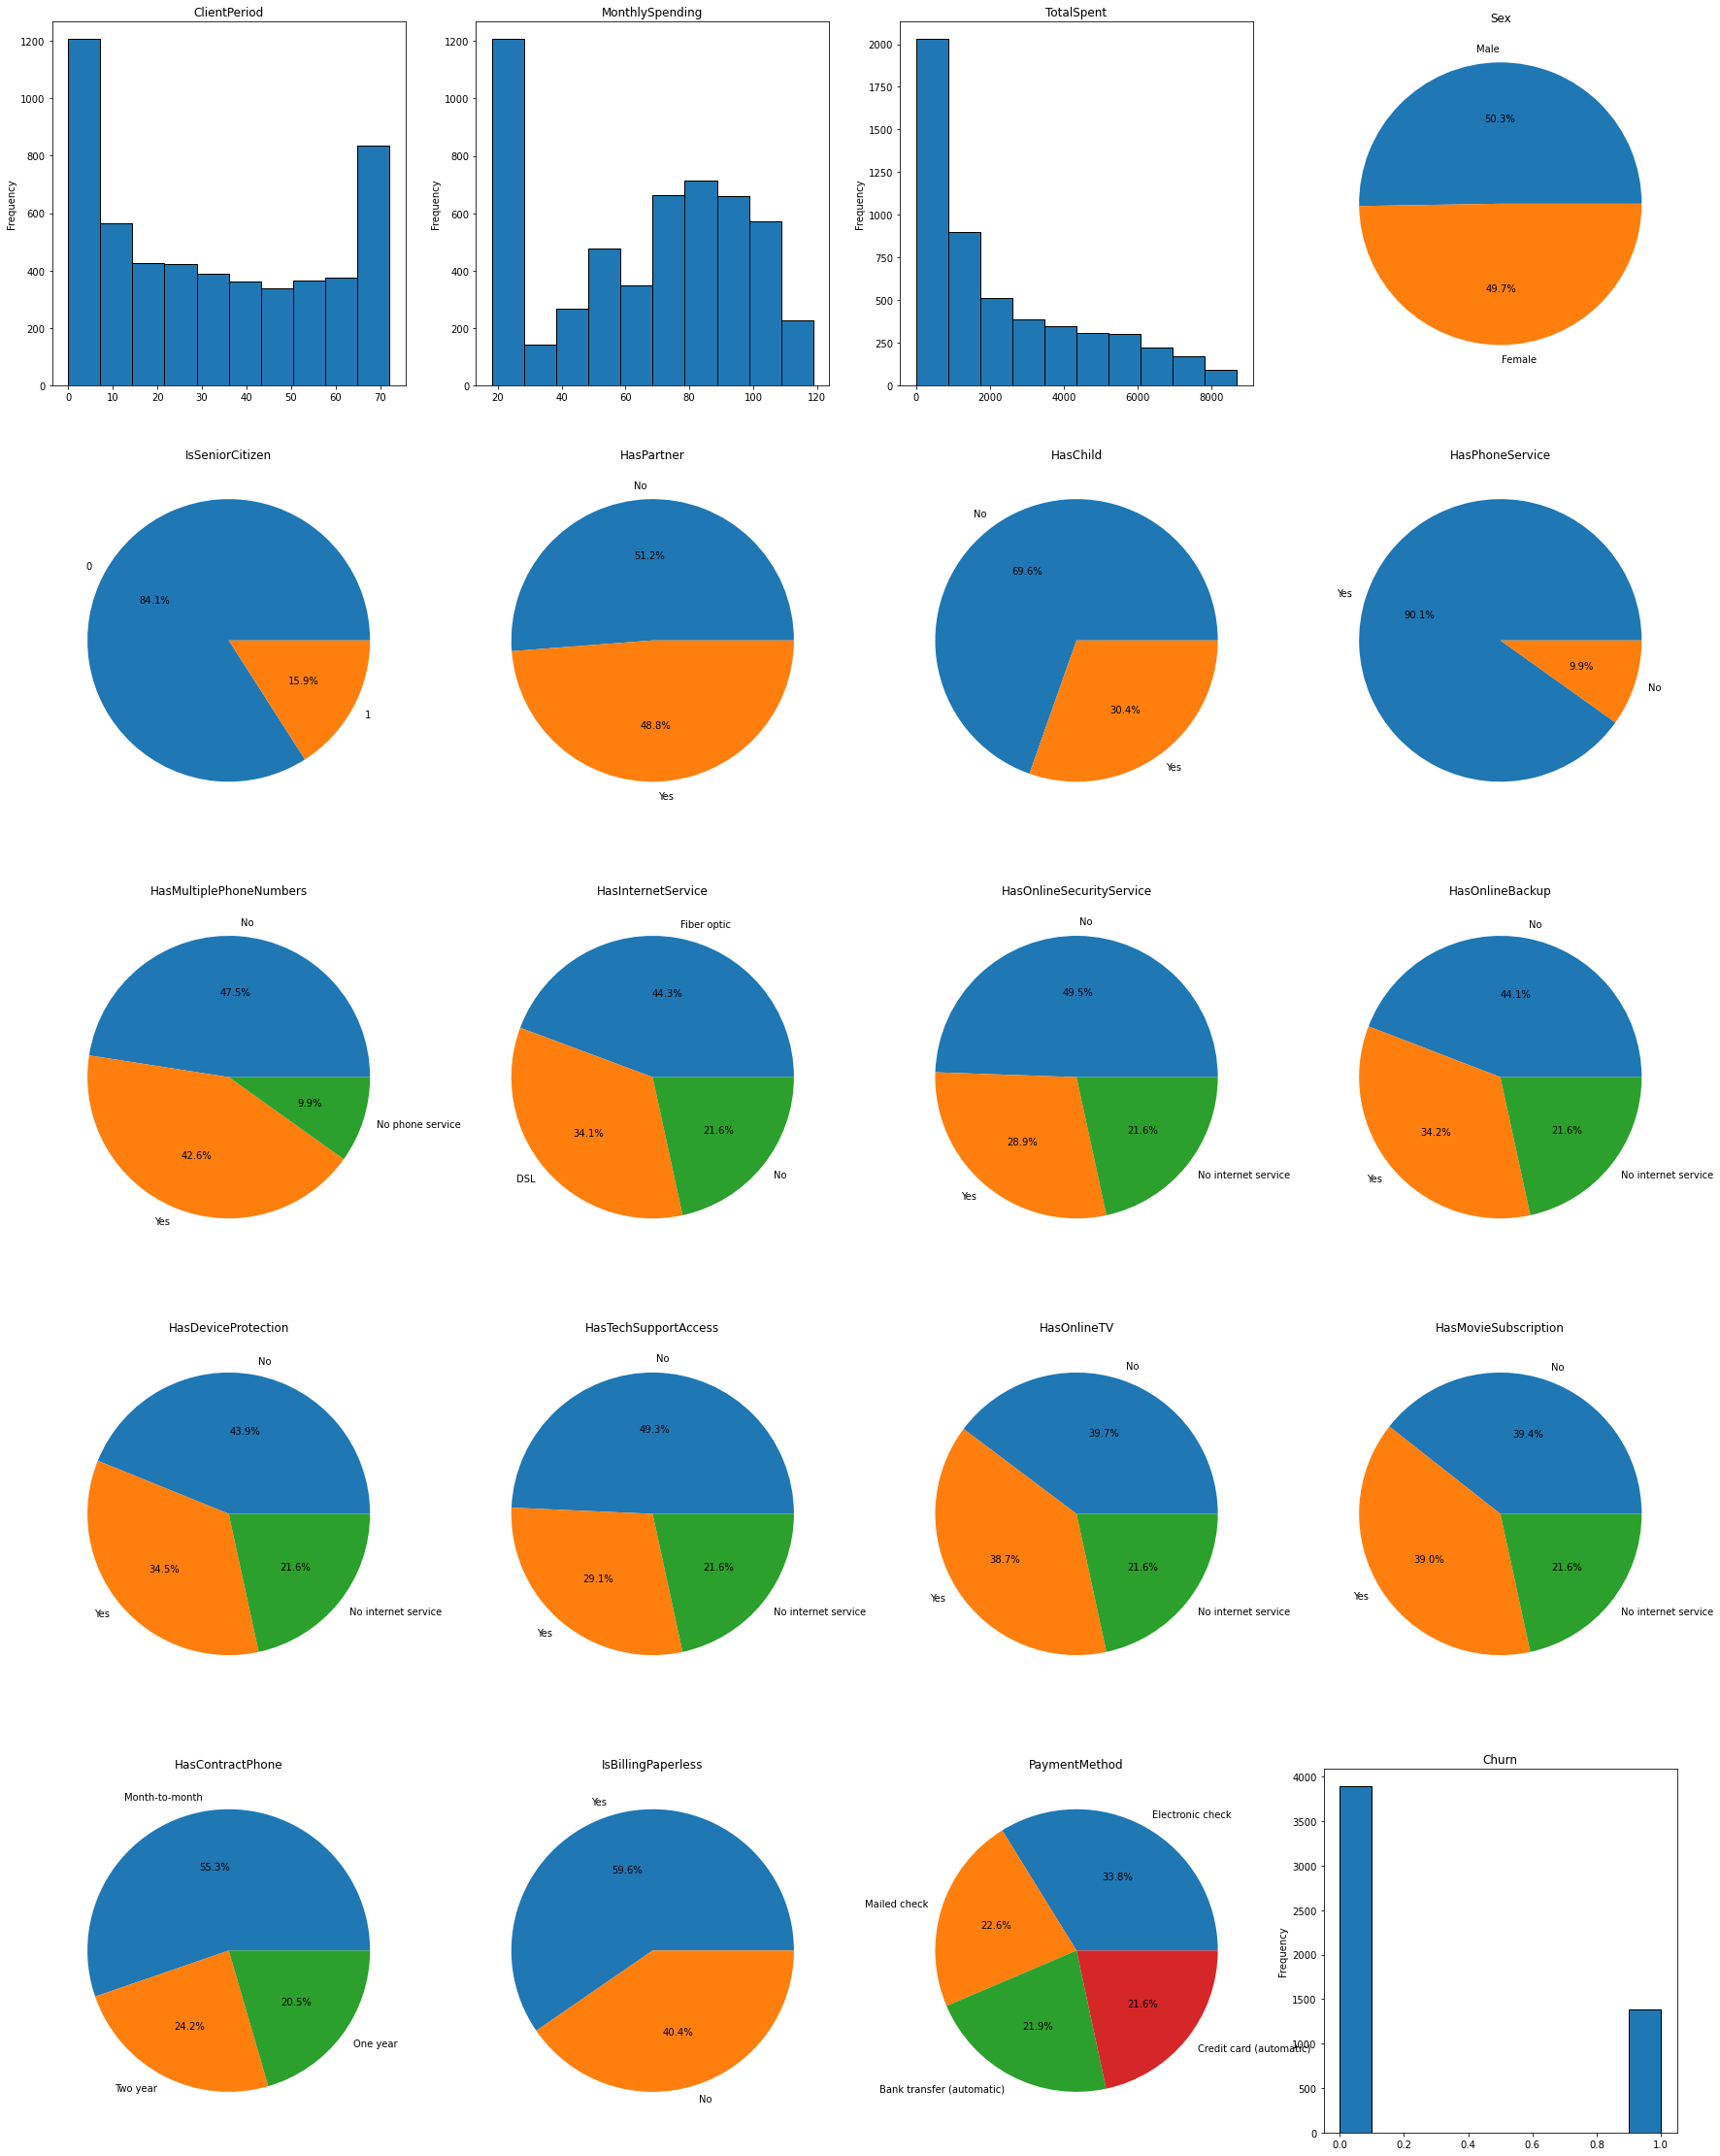

In [265]:
fig, axes = plt.subplots(5, 4, figsize=(30, 40))
for ax, col in zip(axes.flatten(), data.columns):
    ax.set_title(col)
    if col in cat_cols or col == target_col[0]:
        ax.pie(train_df[col].value_counts(), labels=train_df[col].value_counts().index ,autopct="%1.1f%%")
    else:
        train_df[col].plot(kind="hist", ec="black", ax=ax)

Целевая переменная является почти сбалансированной, где-то в 2.5 раза больше класса 0, чем класса 1. Это означает, что количество людей, которые остались, превосходит количество тех, кто ушли.

Можно заметить, что никакую ценность не несут значения 'No internet service' и 'No phone service', так как есть отдельный признак 'HasPhoneService' и 'HasInternetService'. Их можно заменить просто на 'No'.

In [271]:
train_df.replace('No internet service', 'No', inplace = True)
test_df.replace('No internet service', 'No', inplace = True)
train_df.replace('No phone service', 'No', inplace = True)
test_df.replace('No phone service', 'No', inplace = True)
test_df

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod
0,42,56.10,2386.85,Male,0,Yes,No,Yes,Yes,DSL,Yes,No,No,No,No,No,One year,No,Credit card (automatic)
1,29,98.50,3004.15,Male,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check
2,9,76.25,684.85,Male,0,No,No,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check
3,67,74.00,4868.4,Female,0,Yes,Yes,Yes,Yes,DSL,Yes,Yes,No,Yes,Yes,No,Two year,No,Credit card (automatic)
4,71,20.10,1389.6,Female,0,Yes,Yes,Yes,No,No,No,No,No,No,No,No,Two year,No,Bank transfer (automatic)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1756,71,105.15,7555,Female,0,Yes,No,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Two year,Yes,Bank transfer (automatic)
1757,13,20.85,272.35,Female,0,Yes,Yes,Yes,No,No,No,No,No,No,No,No,Two year,No,Mailed check
1758,2,91.45,171.45,Male,0,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,No,Month-to-month,Yes,Electronic check
1759,19,89.10,1620.8,Female,0,Yes,No,Yes,Yes,Fiber optic,No,Yes,No,No,No,Yes,Month-to-month,Yes,Electronic check


## Применение линейных моделей 

1) Обработал данные - отнормировал числовые признаки с помощью StandardScaler, а категориальные закодировал с помощью one-hot-encoding'а. 

2) Попробовал разлчиные модели, в поиске той, которая даст наибольшее значение по метрике ROC-AUC, эксперементируя с гиперпараметрами.

In [454]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, LinearRegression, SGDRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier

### Нормировка признаков

#### One-hot-encoding

In [291]:
numeric_data = train_df[num_cols]
categorial_data = train_df[cat_cols]

In [292]:
dummy_features = pd.get_dummies(categorial_data)
x_train = pd.concat([numeric_data, dummy_features], axis=1)
y_train = train_df.iloc[:,-1]

In [313]:
numeric_data_test = test_df[num_cols]
categorial_data_test = test_df[cat_cols]
dummy_features_test = pd.get_dummies(categorial_data_test)
x_test = pd.concat([numeric_data_test, dummy_features_test], axis=1)

#### StandardScaler

In [318]:
scaler = StandardScaler()

train_df_scaled = scaler.fit_transform(train_df[num_cols])
test_df_scaled = scaler.transform(test_df[num_cols])

In [319]:
x_train[num_cols] = train_df_scaled
x_test[num_cols] = test_df_scaled
x_train

,ClientPeriod,MonthlySpending,TotalSpent,IsSeniorCitizen,Sex_Female,Sex_Male,HasPartner_No,HasPartner_Yes,HasChild_No,HasChild_Yes,...,HasMovieSubscription_Yes,HasContractPhone_Month-to-month,HasContractPhone_One year,HasContractPhone_Two year,IsBillingPaperless_No,IsBillingPaperless_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0.920767,-1.505447,-0.555852,0,0,1,0,1,0,1,...,0,0,1,0,1,0,0,0,0,1
1,1.613288,-1.294998,-0.183039,0,0,1,0,1,1,0,...,0,0,0,1,1,0,0,1,0,0
2,-1.279005,0.363737,-0.974768,0,0,1,1,0,1,0,...,0,1,0,0,0,1,0,0,1,0
3,-0.016173,0.476418,0.124519,1,1,0,0,1,1,0,...,0,1,0,0,1,0,0,0,0,1
4,1.124450,1.667856,1.970599,0,1,0,0,1,0,1,...,1,0,0,1,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5277,-1.197532,-1.144204,-0.972013,0,0,1,1,0,1,0,...,0,1,0,0,1,0,0,0,1,0
5278,0.717084,-0.678565,-0.043651,0,0,1,0,1,1,0,...,0,0,1,0,0,1,1,0,0,0
5279,-1.279005,-0.327265,-0.983957,0,0,1,1,0,1,0,...,0,1,0,0,1,0,0,0,0,1
5280,-0.138382,0.367051,-0.031838,0,1,0,1,0,1,0,...,0,1,0,0,0,1,0,1,0,0


In [333]:
x_train_train, x_train_test, y_train_train, y_train_test = train_test_split(x_train, y_train, test_size=0.5)

LogisticRegression

In [428]:
grid_model = GridSearchCV(
        LogisticRegression(),
        scoring = 'roc_auc',
        param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100]},
        cv = 5, verbose=True, n_jobs=-1
        )
lgrg = grid_model.fit(x_train, y_train)
print(f"best score: {lgrg.best_score_}")
print(f"best params: {lgrg.best_params_}")

Fitting 5 folds for each of 6 candidates, totalling 30 fits
best score: 0.8451306085373114
best params: {'C': 100}


LinearRegression

In [440]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = {"eta0": [ .0001, .001, .003, .01, .03, .1, .3, 1, 3]} 
linear_regression_model = SGDRegressor(tol=.0001) 
random_search = RandomizedSearchCV(linear_regression_model, 
                                   param_distributions=param_dist, 
                                   n_iter=8, 
                                   cv=3, 
                                   scoring='roc_auc') 
random_search.fit(x_train, y_train) 

print("Лучшие параметры: {}".format(random_search.best_params_)) 
print("Лучшая оценка MSE: {}".format(random_search.best_score_))

Лучшие параметры: {'eta0': 0.001}
Лучшая оценка MSE: 0.8373788146292679


RandomForest

In [513]:
PARAMS = {
    "min_samples_split": [9], # range(2,20)
    "min_samples_leaf": [19] # range(2,20)
}
clf = RandomForestClassifier(n_estimators=200, random_state=40)

grid_search = GridSearchCV(clf, PARAMS, scoring="roc_auc", cv=5)
rf = grid_search.fit(x_train_train, y_train_train)

In [514]:
print(f"Best score: {rf.best_score_}")
print(f"Best params: {rf.best_params_}")

Best score: 0.849394651502878
Best params: {'min_samples_leaf': 19, 'min_samples_split': 9}


Лучшие параметры: RandomForestClassifier(min_samples_split = 9, min_samples_leaf = 19, n_estimators=200, random_state=40), Best score: 0.849394651502878

In [450]:
submission = pd.read_csv("submission.csv")
submission["Churn"] = lgrg.predict_proba(x_test)[:, 1]
submission.to_csv("lgrg.csv", index=False)

## Применение градиентного бустинга

Я буду использовать catboost, поэтому не надо кодировать категориальные признаки, а численные признаки нормировать для моделей, основанных на деревьях не нужно. Подобрал лучшие гиперпараметры, которые дали лучше результат, чем случайный лес.

In [518]:
catboost = CatBoostClassifier(
    cat_features=cat_cols,
    logging_level="Silent",
    eval_metric="AUC:hints=skip_train~false",
    grow_policy="Lossguide",
    metric_period=1000,
    random_seed=0
)

PARAMS = {
    "n_estimators": [250],  # [5, 10, 20, 30, 40, 50, 70, 100, 150, 200, 250, 300, 500, 1000],
    "learning_rate": [0.05],  # [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.02, 0.04, 0.05, 0.1, 0.2, 0.3, 0.5],
    "max_depth": [4],  # np.arange(4, 20, 1),
    "l2_leaf_reg": [10],  # np.arange(0.1, 1, 0.05),
    "subsample": [0.6],  # [3, 5, 7, 10],
    "random_strength": [5],  # [1, 2, 5, 10, 20, 50, 100],
    "min_data_in_leaf": [100]  # np.arange(10, 1001, 10),
}
catboost.grid_search(PARAMS, train_df.iloc[:, :-1], train_df.iloc[:,-1], cv=5, plot=True, refit=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	loss: 0.8681264	best: 0.8681264 (0)	total: 29.7s	remaining: 0us
Estimating final quality...


{'params': {'min_data_in_leaf': 100,
  'random_strength': 5,
  'depth': 4,
  'l2_leaf_reg': 10,
  'iterations': 250,
  'subsample': 0.6,
  'learning_rate': 0.05},
 'cv_results': defaultdict(list,
             {'iterations': [0, 249],
              'test-AUC-mean': [0.6738448428910353, 0.848150440977052],
              'test-AUC-std': [0.03568219871124697, 0.01491232030260835],
              'train-AUC-mean': [0.674286151981913, 0.8662277514836992],
              'train-AUC-std': [0.045687735616764, 0.0030760473170784734],
              'test-Logloss-mean': [0.6746293084649804, 0.41027763916805615],
              'test-Logloss-std': [0.0012264681423689151,
               0.017607616411752475],
              'train-Logloss-mean': [0.6745106344821561, 0.38913850934181715],
              'train-Logloss-std': [0.0015597023202042711,
               0.004197658216176103]})}

In [521]:
print("Best score:", catboost.best_score_)
print("Best params:", catboost.get_params())

Best score: {'learn': {'Logloss': 0.3914427123544701, 'AUC': 0.8642032782485164}}
Best params: {'random_seed': 0, 'logging_level': 'Silent', 'metric_period': 1000, 'eval_metric': 'AUC:hints=skip_train~false', 'cat_features': ['Sex', 'IsSeniorCitizen', 'HasPartner', 'HasChild', 'HasPhoneService', 'HasMultiplePhoneNumbers', 'HasInternetService', 'HasOnlineSecurityService', 'HasOnlineBackup', 'HasDeviceProtection', 'HasTechSupportAccess', 'HasOnlineTV', 'HasMovieSubscription', 'HasContractPhone', 'IsBillingPaperless', 'PaymentMethod'], 'grow_policy': 'Lossguide', 'min_data_in_leaf': 100, 'random_strength': 5, 'depth': 4, 'l2_leaf_reg': 10, 'iterations': 250, 'subsample': 0.6, 'learning_rate': 0.05}


In [524]:
submission = pd.read_csv("submission.csv")
submission["Churn"] = catboost.predict_proba(test_df)[:, 1]
submission.to_csv("catboost.csv", index=False)

# Предсказания

In [525]:
best_model = catboost